# Homework 2 (HW2)

---
By the end of this homework we expect you to be able to:
1. Preprocess data and make it amenable to statistical analysis and machine learning models;
2. Train and test out-of-the-box machine learning models in Python;
3. Carry out statistical hypothesis testing;
4. Carry out simple multivariate regression analyses;
5. Use techniques to control for covariates;

---

## Important Dates

- Homework release: Fri 12 Nov 2021
- **Homework due**: Fri 26 Nov 2021, 23:59
- Grade release: Fri 03 Dec 2021

---

##  Some rules

1. You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, 
you may do so, but must justify your choice.
2. Make sure you use the `data` folder provided in the repository in read-only mode. (Or alternatively, be sure you 
don’t change any of the files.)
3. Be sure to provide a textual description of your thought process, the assumptions you made, the solution you 
implemented, and explanations for your answers. A notebook that only has code cells will not suffice.
4. For questions containing the **/Discuss:/** prefix, answer not with code, but with a textual explanation
 (**in markdown**).
5. Back up any hypotheses and claims with data, since this is an important aspect of the course.
6. Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a 
single notebook (plus the required data files) in the *master/main* branch. If there are multiple notebooks present, 
we will **not grade** anything.
7. We will **not run your notebook for you**! Rather, we will grade it as is, which means that only the results 
contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. 
Thus, be sure to hand in a **fully-run and evaluated notebook**. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.
8. In continuation to the previous point, interactive plots, such as those generated using `plotly`, should be **strictly avoided**!
9. Make sure to print results or dataframes that confirm you have properly addressed the task.

---

## Context

Congratulations! You have just been hired as a data scientist at *Piccardi Music,* a promising new music label created by a mysterious Italian disc jockey "*Signor Piccardi*". The company hired you to carry out a variety of data-related tasks, which will be explained in further detail below.

---

## The data

For this homework you will use a dataset of 18,403 music reviews scraped from Pitchfork¹, including relevant metadata such as review author, review date, record release year, review score, and genre, along with the respective album's audio features pulled from Spotify's API. The data consists of the following columns:

| Column   | Description  |
|----------|:-------------|
| `artist`           | The name of the artist who created the album being reviewed. |
| `album`            | The name of the album being reviewed. |
| `recordlabel`      | The name of the record label(s) who published the album. |
| `releaseyear`      | The year that the album was released. |
| `score`            | The score given to the album by the reviewer on a scale of 0.0 to 10.0. |
| `reviewauthor`     | The name of the author who reviewed the album. |
| `genre`            | The genre assigned to the album by Pitchfork. |
| `reviewdate`       | The date that the review was published.  |
| `key` | The estimated overall musical key of the track. Integers map to pitches using standard Pitch Class notation (e.g., 0 = C, 2 = D, and so on) |
| `acousticness` | A confidence measure from 0.0 to 1.0 of whether an album is acoustic. 1.0 represents high confidencethat the album is acoustic. |
| `danceability` | How suitable an album is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 1.0 is most danceable.
| `energy` | A perceptual measure of intensity and activity, from 0.0 to 1.0, where 1.0 represents high energy. Metal is often high energy. |
| `instrumentalness` | Predicts whether an album contains no vocals, from 0.0 to 1.0. The closer to 1.0, the more likely the album contains no vocals. |
| `liveness` | Detects the presence of an audience, from 0.0 to 1.0. Scores greater than 0.8 indicate a strong likelihood the album is live. |
| `loudness` | The overall loudness of the album in decibels (dB). |
| `speechiness` | Measures the presence of spoken words in an album on a scale from 0.0 to 1.0. Scores higher than 0.66 indicate an album made entirely of spoken words, while scores below 0.33 indicate music and other non-speech-like elements. |
| `valence` | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by an album, where values closer to 1.0 indicate more positive sounds. |
| `tempo` | The overall estimated tempo of an album in beats per minute (BPM). |

¹Pinter, Anthony T., et al. "P4KxSpotify: A Dataset of Pitchfork Music Reviews and Spotify Musical Features." Proceedings of the International AAAI Conference on Web and Social Media. Vol. 14. 2020.

In [58]:
# 'pip install yellowbrick'

from yellowbrick.regressor import ResidualsPlot # move to imports cell
# we use yellowbrick for better visualization in 3.3

import math

# pandas / numpy
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# datetime operations
from datetime import datetime

# ttest, euclidean distance and standard error of the mean 
from scipy.stats import ttest_ind
from scipy.spatial.distance import seuclidean
from scipy.stats import sem

# linear fit using statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# good ole sklearn
from sklearn.metrics import euclidean_distances, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

# displaying markdown strings
from IPython.display import display, Markdown, Latex

#add function for task2 
from sklearn.model_selection import train_test_split

#add function for task5
from statsmodels.stats import diagnostic
import scipy.stats

## Part 1: Will this album be a hit?

The first project you embark on in your new job is to build a regressor to predict whether an album will be well received or not. According to *Signor Piccardi* (your boss), this algorithm may eventually be helpful in forecasting the success of albums produced by *Piccardi Music*.

**Task 1 (Initial analyses — 10 pts)**

As a good data scientist, the first thing you do is to have a good look at the data that was handed to you.

1. Load the data using `pandas`. Identify and remove duplicate reviews, i.e., two reviews with albums by the same band with the same name (keep the first occurrence). Print the number of rows in your dataframe.

2. Plot the distribution of album release years and the average score of albums per year.

3. For numerical columns, calculate the mean, median, minimum value and maximum value. Additionally, plot the distribution for all the numerical columns in a single image (possibly with multiple subplots). Your image should be at most 14 inches wide by 14 inches long.

3. For categorical columns, list how many different values there are in each column. If there are less than 10 distinct values for a category, print them all. For the `genre` column, assign the value `'Other'` for albums where the value is either `'none'` or `NaN`.

5. **Discuss:** This dataset was built with *found data*—i.e., the Pitchfork reviews were not made with the goal of training a machine learning model. Grounded on the previous analyses and in Pitchfork's [Wikipedia page](https://en.wikipedia.org/wiki/Pitchfork_(website)), point **three** (exactly!) ways in which this data may not be representative of music albums in general due to the way the data was collected. 

---

In [59]:
#1.1.1

data = pd.read_csv('data/pitchfork.csv.gz', compression='gzip')

In [60]:
#1.1.2

# Make a copy of the original data
df = data.copy()
# We check if there is in fact duplicate rows
print('Number of duplicate rows :', (data.shape[0]- df.shape[0]))

Number of duplicate rows : 0


In [61]:
# Drop duplicates from df and keep the first row of the duplicate rows
df.drop_duplicates(subset = ['artist','album'], keep = 'first',inplace = True) 

In [62]:
#1.1.3

# Number of rows in df
print('Number of rows in dataframe is :', df.shape[0])

Number of rows in dataframe is : 16738


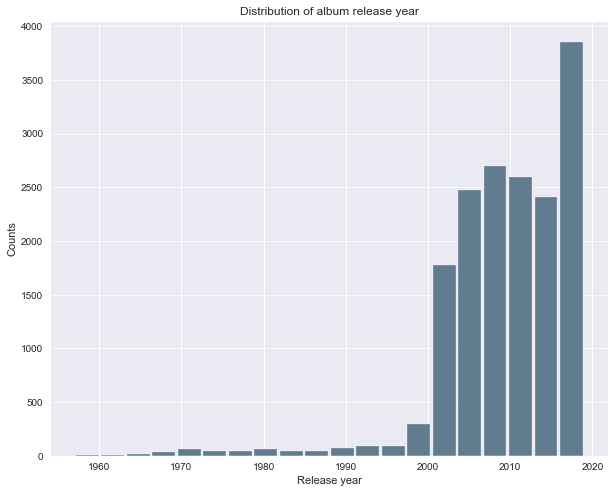

In [63]:
#1.2

# Plot the distribution of album per release year.
df['releaseyear'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e',figsize=(10,8))
plt.title('Distribution of album release year')
plt.xlabel('Release year')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)
plt.show()

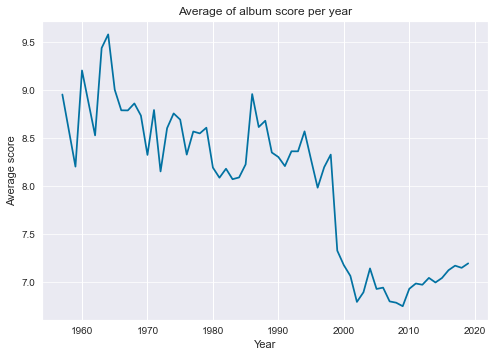

In [64]:
#calculate mean score per year
average_per_year = df.groupby('releaseyear')['score'].mean()
year = average_per_year.index[:]
average = average_per_year.values[:]
#plot the mean score per year
plt.plot(year,average)
plt.title('Average of album score per year')
plt.xlabel('Year')
plt.ylabel('Average score')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [65]:
# 1.3.1

# Extra step: Change review data to pandas date time format
df['reviewdate']= pd.to_datetime(df['reviewdate'])

In [66]:
# Drop falulty rows, for examplem albums with speeachiness = -1. 
df = df.drop(df[(df.acousticness  < 0) | (df.energy < 0) | (df.instrumentalness < 0)].index)
df

,artist,album,reviewauthor,score,releaseyear,reviewdate,recordlabel,genre,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Studio 1,Studio 1,Andy Battaglia,8.5,2009.0,2009-02-18,Studio,Electronic,0.511917,0.499667,5.250000,-5.626583,0.031983,0.724917,0.024493,0.165367,0.555083,101.395167
1,John Fahey,The Great Santa Barbara Oil Slick,Mark Richardson,8.2,2005.0,2005-02-13,Water,Folk/Country,0.369765,0.325412,4.470588,-19.153824,0.148624,0.647053,0.559133,0.527782,0.179465,107.622647
2,Reigning Sound,Too Much Guitar,Stephen M. Deusner,8.3,2004.0,2004-08-19,In the Red,Electronic,0.253943,0.912857,4.428571,-1.089500,0.055500,0.000253,0.751214,0.199071,0.552786,133.895500
3,The Red Thread,After the Last,Chris Dahlen,7.3,2003.0,2003-07-17,Badman,Rock,0.425400,0.433474,5.700000,-12.871000,0.028260,0.310325,0.224137,0.125150,0.451400,104.354200
4,Mac Miller,Swimming,Evan Rytlewski,7.5,2018.0,2018-08-03,Warner Bros.,Rap,0.624846,0.438154,4.153846,-9.456077,0.170246,0.652462,0.012819,0.121131,0.281138,122.121308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,Flying Lotus,Flamagra,Philip Sherburne,7.8,2019.0,2019-05-24,none,Electronic,0.536750,0.652050,5.350000,-8.583750,0.134820,0.215916,0.519892,0.192075,0.353705,124.988200
16773,YG,4REAL 4REAL,Sheldon Pearce,7.2,2019.0,2019-05-24,none,Rap,0.815429,0.556929,4.785714,-6.327643,0.259721,0.186476,0.000848,0.244586,0.361850,115.455857
16774,Mavis Staples,We Get By,Stephen M. Deusner,7.5,2019.0,2019-05-24,none,Pop/R&B,0.633636,0.374664,5.454545,-10.363000,0.071664,0.710727,0.001982,0.118609,0.619364,114.246818
16775,Amyl and the Sniffers,Amyl and the Sniffers,Stephen Thomas Erlewine,7.2,2019.0,2019-05-24,none,Rock,0.440909,0.876636,5.454545,-3.353182,0.064000,0.000838,0.135113,0.172718,0.591545,119.177454


In [67]:
# Drop columns that are non-numerical
df_n = df.drop(['artist','album','reviewauthor','reviewdate','recordlabel','genre'],axis=1)

stats_matrix = np.zeros((4,12))
stats_matrix[0,:] = df_n.mean()
stats_matrix[1,:] = df_n.median()
stats_matrix[2,:] = df_n.min()
stats_matrix[3,:] = df_n.max()
stats_names = ['Mean','Median','Minimum value','Maximum value']
df_stats = pd.DataFrame(data=stats_matrix,columns=df_n.columns,index=stats_names)
df_stats

,score,releaseyear,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
Mean,7.048536,2009.345965,0.512967,0.601951,5.219034,-9.286912,0.091208,0.302476,0.275303,0.196910,0.405853,120.377216
Median,7.300000,2010.000000,0.511364,0.624823,5.230769,-8.446428,0.056681,0.229000,0.149641,0.174304,0.406300,120.406490
Minimum value,0.000000,1957.000000,0.038667,0.000126,0.000000,-51.728750,0.008644,0.000001,0.000000,0.015300,0.000010,23.983333
Maximum value,10.000000,2019.000000,0.974000,0.999000,11.000000,4.078000,0.958000,0.996000,0.982000,0.978000,0.971000,215.972000


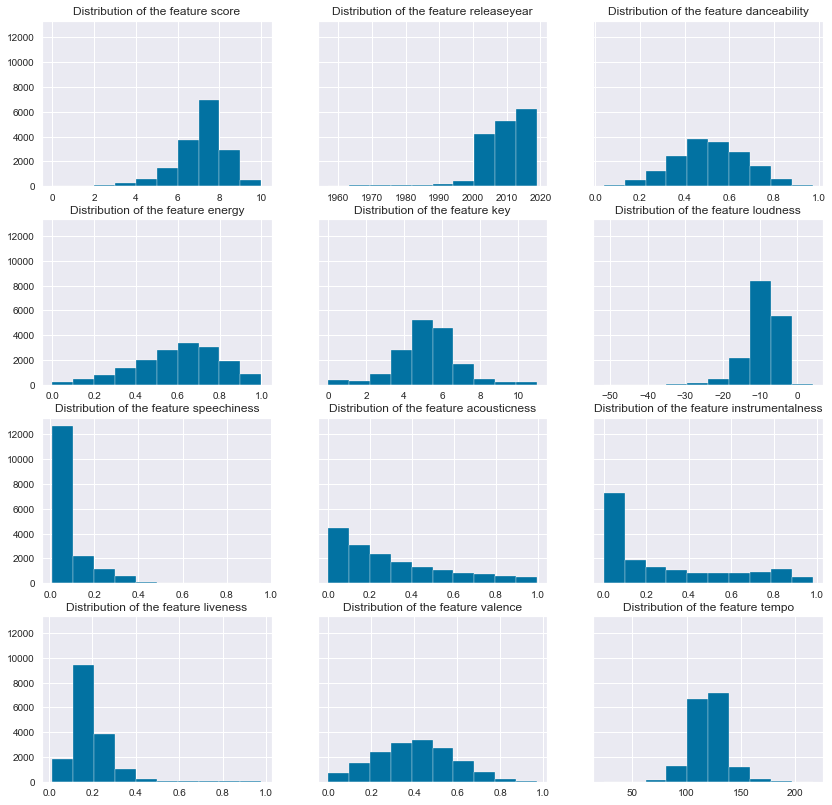

In [68]:
# 1.3.2
sns.set_style('darkgrid')

fig, axs = plt.subplots(4,3, figsize=(14, 14), sharey=True)
column_list = df_stats.columns.values.tolist()
kk = 0

for ii in range(0,4):
    for jj in range(0,3):
        column_name = column_list[kk]
        axs[ii,jj].hist(df[column_name])
        axs[ii,jj].set_title("Distribution of the feature " + column_name)
        kk = kk +1
    
plt.show()

In [69]:
# 1.4

df_categ = df[['artist','album','reviewauthor','reviewdate','recordlabel','genre']]
column_list = df_categ.columns.values.tolist()
for column_name in column_list:
    no_unique_vals = df_categ[column_name].nunique()
    print(column_name, 'column has', no_unique_vals, 'distinct values')
    if (no_unique_vals <= 10):
        print()
        print(column_name, 'column has 10 or less unique values and they are:')
        print(df_categ[column_name].unique())

print()
df['genre'].replace('none', 'Other', inplace=True)
df['genre'] = df['genre'].replace(np.nan, 'Other', regex=True)
print(df['genre'].unique())


artist column has 7890 distinct values
album column has 16176 distinct values
reviewauthor column has 554 distinct values
reviewdate column has 4876 distinct values
recordlabel column has 3030 distinct values
genre column has 10 distinct values

genre column has 10 or less unique values and they are:
['Electronic' 'Folk/Country' 'Rock' 'Rap' 'Global' 'Experimental' 'Metal'
 'Pop/R&B' 'Jazz' 'none']

['Electronic' 'Folk/Country' 'Rock' 'Rap' 'Global' 'Experimental' 'Metal'
 'Pop/R&B' 'Jazz' 'Other']


In [70]:
print('Number of nans in genre column is',df['genre'].isna().sum())
print('Number of "none" in genre column is',len(df[df['genre'] =='none']))
df['genre'] = df['genre'].replace(np.nan, 'Other')
df['genre'] = df['genre'].replace('none', 'Other')

Number of nans in genre column is 0
Number of "none" in genre column is 0


#### End of task 1.4

#### The cells below is to support our discussion in 1.5

In [71]:
df.groupby('genre').count()['artist']

genre
Electronic      3562
Experimental    1638
Folk/Country     734
Global           161
Jazz             278
Metal            754
Other             11
Pop/R&B         1284
Rap             1609
Rock            6699
Name: artist, dtype: int64

<BarContainer object of 3 artists>

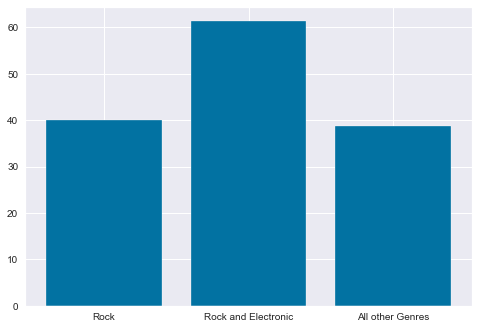

In [72]:
rock_genre = 0
rock_elec_genre = 0
all_other_genre = 0
for idc,val in enumerate(df['genre']):
    if (val=='Rock'):
        rock_genre += 1
    if ( (val=='Rock') or (val=='Electronic') ):
        rock_elec_genre +=1
    if ( (val!='Rock')and (val!='Electronic')):
        all_other_genre +=1
    
bar_heights = np.array([rock_genre,rock_elec_genre,all_other_genre])
bar_heights1 = (bar_heights/df.shape[0])*100
bar_labels= ['Rock','Rock and Electronic','All other Genres']

plt.bar([0,1,2],bar_heights1,tick_label=bar_labels )

##### 1.5

**Discuss**: This dataset was built with found data—i.e., the Pitchfork reviews were not made with the goal of training a machine learning model. Grounded on the previous analyses and in Pitchfork's Wikipedia page, point three (exactly!) ways in which this data may not be representative of music albums in general due to the way the data was collected
1) We grouped the data by genre and found interesting results that are summarized in the bar chart above. We found that 40% of all reviews were albums that belong to the rock genre. We also found that 61.3% of all the albums belonged to the rock and electronic genre, while the other 38.7% of albums belonged to the other 8 other genres. This means that the data is unbalanced and this is an issue for training a machine learning model. It was also shown on the Wikipedia page that one of the critics of Pitchfork is that "In the 2000s the website's journalism favored independent music, favoring lo-fi and often obscure indie rock and giving only cursory treatment to other genres."

2) From the distribution plot of the average score per year of task 1.2, we observed that the average score drops just before the year 2000. We also observed from the distribution of the album release years that there are very few albums reviewed before the 2000s. This makes sense as Pitchfork was founded in 1995. We believe the reason for the drop in score is due to the fact that old albums (those before 1995) are more likely to receive higher scores because old albums are less likely to be reviewed unless the reviewer highly appreciates the old albums or takes only albums that had a big sucess.

3) Reviewing an album depends only on the tastes of the reviewer in music. Since there are only 554 review authors, this means that the scores of music albums are not representative of the opinion of the population. In fact 554 may not be a good sample of the population to take the general opinion.

#### **Task 2 (Pre-processing and pipeline code — 12 pts)**

Next, you decide to prepare the code that will help you in training your machine learning models. Also, you implement a simple baseline. For this task, **unless otherwise stated** you must implement functions yourself, instead of relying on `scikit-learn` (you can use `numpy` or `pandas`, though!).

1. For each possible value in the `genre` column, create a new column called `{genre}_onehot` (e.g., for `genre=jazz`, create `jazz_onehot`). Collectively, these new columns should "one hot-encode" the genre column—for instance, if for a given album the `genre` is filled with the value `jazz`, the `jazz_onehot` column should equal 1 and all other `{genre}_onehot` columns should equal 0. 

2. Create a function `numpy_helper(df, cols)` to obtain a `numpy.array` out of your `dataframe`. The function should receive a dataframe `df` with N rows and a list of M columns `cols`, and should return a `np.array` of dimension (NxM).

3. For each album, build an array of features `X` containing all genre-related one-hot features, and an array of outcomes `y` containing scores. Using the function [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with `random_state=123`, split the data into a train set containing 70% of all data, and a test set containing the remaining 30%.

4. Create your own baseline regressor. Using the training data (in the training stage), your regressor should estimate the average score for all albums. Then, for the test data (in the prediction stage), your classifier should always output the average score (computed on the training data).

5. Calculate the [coefficient of determination ($R^2$)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) of your baseline on the test data. **You are allowed to use the `sklearn` implementation here.**

6. **Discuss:** Your train-test split randomly selected 70% of all data for the training set. Why is this a problem for the broader task of predicting whether a future album will be successful or not?

---

In [73]:
#2.1

# Get all unique genres and make onehot columns for them
genres = df["genre"].unique()
for genre_unique in genres:
    name = genre_unique+'_onehot'
    df[name] = 1*(genre_unique == df['genre'])
# Verify that the new columns has been created 
df.columns

Index(['artist', 'album', 'reviewauthor', 'score', 'releaseyear', 'reviewdate',
       'recordlabel', 'genre', 'danceability', 'energy', 'key', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'Electronic_onehot', 'Folk/Country_onehot',
       'Rock_onehot', 'Rap_onehot', 'Global_onehot', 'Experimental_onehot',
       'Metal_onehot', 'Pop/R&B_onehot', 'Jazz_onehot', 'Other_onehot'],
      dtype='object')

In [74]:
#2.2

def numpy_helper(df, cols):
    # Takes the columns cols in dataframe df and change it to numpy.array
    return df[cols].to_numpy()  
# Verify that the function works 
numpy_helper(df,['album','genre'])

array([['Studio 1', 'Electronic'],
       ['The Great Santa Barbara Oil Slick', 'Folk/Country'],
       ['Too Much Guitar', 'Electronic'],
       ...,
       ['We Get By', 'Pop/R&B'],
       ['Amyl and the Sniffers', 'Rock'],
       ['STFU II EP', 'Pop/R&B']], dtype=object)

In [75]:
#2.3

onehot = np.repeat('_onehot', len(genres))
cols = genres + onehot
X = numpy_helper(df,cols)
y = numpy_helper (df,'score')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

In [76]:
#2.4

# We want to estimate the average score for all albums with only the genre of the albums as variable 
# This correponds to a linear regression that we are going to solve without using sklearn :
X_train_model  = np.c_[np.ones((len(X_train), 1)), X_train] # Add a column of ones
betas = np.linalg.tensorsolve(X_train_model.T.dot(X_train_model), X_train_model.T.dot(y_train))

# We now use our optimal weights to predict on the X_test: 
X_test_model = np.c_[np.ones((len(X_test),1)),X_test]
y_predict_test = X_test_model.dot(betas)

In [77]:
#2.5

R_square = r2_score(y_test, y_predict_test) 
print ("Coeffiecent of determination:", R_square) 

Coeffiecent of determination: 0.011353866407970092


##### 2.6 

**Discuss:** Your train-test split randomly selected 70% of all data for the training set. Why is this a problem for the broader task of predicting whether a future album will be successful or not?

As we can see our coefficient of determination is very small. Usually it represents the fraction of variance unexplained which means that in our case, the regression prediction fit the data very bad. Taking 70% of all data as training data can be one of the reasons why the regression is not good. In fact, some of the genres are underpresented (for example we only have 11 data points with genre Others) and doing a cross validation on such a small set might decrease the results. This problem is called a stratification problem. In fact, when the data is composed by many classes with different proportition in all the data, it's recommended to split randomly selected 70% in each class of the data for the training set. 

**Task 3 (Regression — 14 pts)**

Finally, you get down to business and train your regression models.

1. Build a Linear Regression model (use `sklearn`) that predicts the outcome `score` using the features "releaseyear",  "key", "acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "valence", "tempo" and the one-hot encoded genre-related columns.  Using a 70/30 train-test split similar to what you did in task two (hereinafter referred to as "the random split", use the same random seed, `random_state=123`), report the $R^2$ for the testing set.

2. Create an alternate train-test split (hereinafter referred to as "the longitudinal split") where you train with data from albums released before 2000 and test with data from 2003 and after. Report the $R^2$ for the testing set using the same model you developed for the previous question. **Discuss:** give the correct interpretation of $R^2$ value for the longitudinal split.

3. For a given entry $X$ your model outputs a predicted score $Y'$. The difference between the real score $Y$ and the predicted score $Y'$ is called the "residual". Considering the model trained in 3.2, plot the distribution of your residuals for the test set. Additionally, estimate what is the probability that your score prediction (from 3.2) is off by more than 2-points? Provide bootstrapped confidence intervals for your answer.

4. Experiment with training a different regressor, a Gradient Boosting Regressor. This regressor is related to the Boosted decision trees that you have seen in class. This model performs extremely well for a variety of tasks and is often used in machine learning competitions for tabular data (e.g., on Kaggle). Train the regressor using the longitudinal split and the same features as in 3.2, use the default hyperparameters. Report the $R^2$ for the testing set. 

5. **Discuss:** Hypothesize a reason for the difference in performance between the Linear regression and the Gradient Boosting Regressor.

---

In [78]:
#3.1

task3df = df.drop(['artist', 'album', 'reviewauthor', 'reviewdate', 'recordlabel', 'genre'], axis=1)

# Show the dataframe
task3df.head(1)

,score,releaseyear,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,...,Electronic_onehot,Folk/Country_onehot,Rock_onehot,Rap_onehot,Global_onehot,Experimental_onehot,Metal_onehot,Pop/R&B_onehot,Jazz_onehot,Other_onehot
0,8.5,2009.0,0.511917,0.499667,5.25,-5.626583,0.031983,0.724917,0.024493,0.165367,...,1,0,0,0,0,0,0,0,0,0


In [79]:
# Make an X and y for regression
X = task3df.drop(['score'], axis=1)
y = task3df['score']

# Sample the random split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

# Do linear regression
model = LinearRegression()
reg = model.fit(X_train, y_train)

# Predict y
y_pred = reg.predict(X_test)

In [80]:
# Check the R2 score of the prediction
print("R2 score: {}".format(r2_score(y_test, y_pred)))

R2 score: 0.038669870192804434


In [90]:
#3.2

# Create "the longitudinal split"
train_long = task3df[task3df.releaseyear <= 2000]
test_long = task3df[task3df.releaseyear >= 2003]
x_test_long = test_long.drop(['score'], axis=1)
y_test_long = test_long['score']
x_train_long = train_long.drop(['score'], axis=1)
y_train_long = train_long['score']

# Do the linear regression
model = LinearRegression()
reg = model.fit(x_train_long, y_train_long)
y_pred_long = reg.predict(x_test_long)

In [82]:
# Check the R2 score of the prediction
print("R2 score: {}".format(r2_score(y_test_long, y_pred_long)))

R2 score: -0.14788594714654701


##### 3.2
**Discussion**: Give the correct interpretation of  𝑅2  value for the longitudinal split.

The model trained on pre-2000 data is very bad at predicting scores post-2000.

In [83]:
#3.3

# Make a series of the residual
residual_dist = y_test_long - y_pred_long

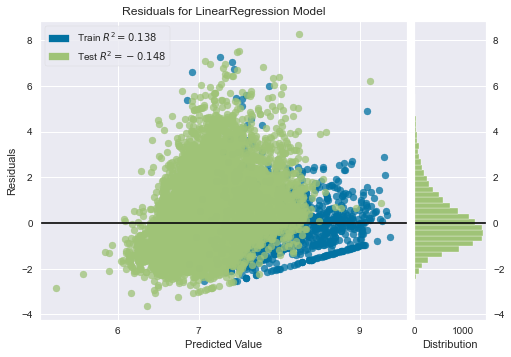

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [105]:
model = LinearRegression()
visualizer = ResidualsPlot(model)

# Fit the training data to the visualizer
visualizer.fit(x_train_long, y_train_long)  
# Evaluate the model on the test data
visualizer.score(x_test_long, y_test_long)  
visualizer.show() 

In [29]:
# Calculate the probability that its off by more than 2
print('Probability that it is off by more than 2:', len(residual_dist[residual_dist >= 2])/len(residual_dist))

Probability that it is off by more than 2: 0.011190992946283234


In [30]:
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

print("95% bootstrapped confidence intervals: {}".format(bootstrap_CI(residual_dist, 1000)))

95% bootstrapped confidence intervals: [-0.14423477147132419, -0.10413739480271278]


In [31]:
#3.4

# Using Grading boosting regressor
reg = GradientBoostingRegressor()
reg.fit(x_train_long, y_train_long)
boost_pred = reg.predict(x_test_long)

In [32]:
print("R2 score: {}".format(r2_score(y_test_long, boost_pred)))

R2 score: -0.307016507976434


##### 3.5
**Discuss:** Hypothesize a reason for the difference in performance between the Linear regression and the Gradient Boosting Regressor.

One of the assumptions of linear regression is homoscedasticity. From the residual plot in 3.3, we can see that the residual does not have a constant variance. Hence, the gradient boosting regressor should perform better.

On the other hand there is a clear difference in mean score in pre-2000 data compared to data after 2000 as discussed earlier. The difference might be because using pre 2000 data to predict after 2003 data could have a bad fit. The linear regression could be bad at fitting pre-2000 data. The gradient boosting regressor could be better at fitting the 2000 data, which could in turn be even worse at predicting data after 2003.

**Task 4 (Are we solving the correct problem? — 16 pts)**

All your efforts so far have assumed that decisions are taken at the "album" level, which is often not the case for bands with multiple albums. In those cases, it could be interesting to predict what is the success of a given band album given the features of the album **and of previous albums**.

1. Create a new dataframe that contains one row per band with more than 1 album. This dataframe should have the same columns as the data provided to you, considering the latest album of the respective band (note that this is determined by the release year of the album, not the date when it was reviewed). Additionally, for each feature considered in Task 3.1 (including the one-hot encoded features), create an additional column post-fixed with `_previous` (e.g., `danceability_previous`). These columns should contain the average values for all of the band's previous albums. Also, create a column `score_previous` with the average score of previous albums. Print the number of rows in the dataframe as well as the name of the columns.

2. Train a Gradient Boosting Regressor considering all features created in Task 4.1 (note that `score` is the outcome and everything else is a feature, including `score_previous`). Use the 70/30 random train-test split, the default hyperparameters, and report the $R^2$ for the testing set. 

3. Can hyperparameter tuning improve your model? Write modular code (i.e., a function) to divide your training data into $N$ folds and perform cross-validation. Experiment tuning two hyperparameters of the Gradient Boosting Regressor: `n_estimators` and `learning_rate`. For each possible combination of the two hyperparameters (see below for the range of values that you should try for each hyperparameter), train your model in a cross-validation setup with $N=20$ folds. Report the mean  $R^2$ along with the 90% CI for each scenario. 
    - n_estimators $ \in  \{ 100, 200, 300, 400\}$
    - learning_rate $ \in  \{ 0.1, 0.05, 0.01\}$.
 
 With the best hyperparameters obtained, train your model with the entire training set and report the $R^2$ on the testing set.
 
4. **Discuss:** How do these results compare with the previous setup (the scenario considered in **Task 3.4**)? Point out two reasons why it is hard to compare the results obtained in 4.3 and 3.4 at face value? How would you fairly compare the two different setups?

---

In [33]:
# 4.1

# Create a function to extract a list containing the artists with multiple albums
def get_artists_with_multiple_albums(df):
    number_of_alb_df = df.groupby(['artist']).size()
    N = number_of_alb_df.shape[0]
    artists_list= []
    albums_per_artist = []
    for ii in range(0,N):
        n_albums = number_of_alb_df.iloc[ii]
        if (n_albums>1):
            artist = number_of_alb_df.index[ii]
            artists_list.append(artist)
            albums_per_artist.append(number_of_alb_df[ii])
    return artists_list

In [34]:
artists_list = get_artists_with_multiple_albums(df)
print('Number of artists with multiple albums:', len(artists_list))

Number of artists with multiple albums: 3561


In [35]:
# Create a data frame (df_ma) by keeping only the rows that contain artists with multiple albums
df_ma = df.loc[df['artist'].isin(artists_list)]

In [36]:
'''
function (create_df_with_multiple_artists) creates a dataframe that its rows only contain multiple artists and 
computes the avearge for the previous values.
'''
def create_df_with_multiple_artists(df,artists_list):
#   INPUTS: 

#  df: input dataframe, it should contain only rows for artists with multiple albums

#  artists_list: list containing the artists with multiple albums


#  OUTPUTS: 

#  df_task: dataframe with only rows for artists with multiple albums and the previous values


    basic_columns = df.columns.values
    pre_columns =  basic_columns.copy()
    pre_cols_clean = np.delete(pre_columns,[0,1,2,5,6,7])
    string = '_previous'
    pre_cols_clean_labeled = [x + string for x in pre_cols_clean]
    full_list_of_cols = np.concatenate((basic_columns, pre_cols_clean_labeled))
    df_task4 =  pd.DataFrame(columns=full_list_of_cols,index=[0])
    N = len(artists_list)
    for ii in range(0,N):
        artist = artists_list[ii]
        artist_block_df = df[df['artist']==artist]
        artist_block_df_sorted = artist_block_df.sort_values(by=['releaseyear'],ascending=False)
        years_sorted = artist_block_df_sorted['releaseyear']
        if ( (years_sorted.iloc[0]) > (years_sorted.iloc[1]) ):
            current_row =  artist_block_df_sorted.iloc[0:1,:]
            for idx,newcol in enumerate(pre_cols_clean_labeled):
                current_row[newcol] = artist_block_df_sorted[pre_cols_clean[idx]].iloc[1:].mean()
            df_task4.loc[ii,:] = current_row.iloc[0,:]
        elif ( (years_sorted.iloc[0]) == (years_sorted.iloc[1]) ):
            artist_block_df_sorted_chosen = artist_block_df_sorted.loc[artist_block_df_sorted['releaseyear']==years_sorted.iloc[0]]
            artist_block_df_sorted_chosen_sorted_again = artist_block_df.sort_values(by=['reviewdate'],ascending=False)
            current_row =  artist_block_df_sorted_chosen_sorted_again.iloc[0:1,:]
            for idx,newcol in enumerate(pre_cols_clean_labeled):
                current_row[newcol] = artist_block_df_sorted_chosen_sorted_again[pre_cols_clean[idx]].iloc[1:].mean()
            df_task4.loc[ii,:] =current_row.iloc[0,:]
        
    return df_task4

In [117]:
pd.options.mode.chained_assignment = None  # default='warn'
df_task4 = create_df_with_multiple_artists(df_ma,artists_list)

In [123]:
print('The number of rows is ',df_task4.shape[0], "\n")
print('The columns names are: ')
for col in df_task4.columns:
    print(col)

The number of rows is  3561 

The columns names are: 
artist
album
reviewauthor
score
releaseyear
reviewdate
recordlabel
genre
danceability
energy
key
loudness
speechiness
acousticness
instrumentalness
liveness
valence
tempo
Electronic_onehot
Folk/Country_onehot
Rock_onehot
Rap_onehot
Global_onehot
Experimental_onehot
Metal_onehot
Pop/R&B_onehot
Jazz_onehot
Other_onehot
score_previous
releaseyear_previous
danceability_previous
energy_previous
key_previous
loudness_previous
speechiness_previous
acousticness_previous
instrumentalness_previous
liveness_previous
valence_previous
tempo_previous
Electronic_onehot_previous
Folk/Country_onehot_previous
Rock_onehot_previous
Rap_onehot_previous
Global_onehot_previous
Experimental_onehot_previous
Metal_onehot_previous
Pop/R&B_onehot_previous
Jazz_onehot_previous
Other_onehot_previous


In [124]:
# 4.2

# Drop categorical rows
df_task4_dropped = df_task4.drop(['artist','album','reviewauthor','reviewdate','recordlabel','genre'],axis=1)
X = df_task4_dropped.drop(['score'], axis=1)
y = df_task4_dropped['score']

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

# Gradient Boosting Regressor
reg = GradientBoostingRegressor()
reg.fit(X_train, y_train)
boost_pred = reg.predict(X_test)

In [128]:
print("R2 score: {}".format(r2_score(y_test,boost_pred)))

R2 score: 0.23228596920589994


In [129]:
df_task4_dropped.shape

(3561, 44)

In [130]:
# 4.3

from sklearn.model_selection import GridSearchCV

reg = GradientBoostingRegressor()
param_grid = {
    'n_estimators':[100,200,300,400],
    'learning_rate':[0.1,0.05,0.01]
}

grid_search = GridSearchCV(estimator = reg, param_grid = param_grid, cv = 20)

In [131]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=20, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'n_estimators': [100, 200, 300, 400]})

In [173]:
Arr_with_params = grid_search.cv_results_["params"]

In [174]:
# Function to calculate CI 
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [175]:
for count,item in enumerate(Arr_with_params):
    temp_arr = grid_search.cv_results_['split'+str(count)+'_test_score']
    mean_m, mean_m_low, mean_m_high = mean_confidence_interval(temp_arr, confidence=0.90)
    print('For',item,'the  mean  𝑅2 is ',round(mean_m, 3), 'And the 95% CI is between',round(mean_m_low, 3), '', round(mean_m_high, 3))

For {'learning_rate': 0.1, 'n_estimators': 100} the  mean  𝑅2 is  0.016 And the 95% CI is between -0.007  0.04
For {'learning_rate': 0.1, 'n_estimators': 200} the  mean  𝑅2 is  0.136 And the 95% CI is between 0.12  0.152
For {'learning_rate': 0.1, 'n_estimators': 300} the  mean  𝑅2 is  0.084 And the 95% CI is between 0.071  0.097
For {'learning_rate': 0.1, 'n_estimators': 400} the  mean  𝑅2 is  0.213 And the 95% CI is between 0.189  0.238
For {'learning_rate': 0.05, 'n_estimators': 100} the  mean  𝑅2 is  0.023 And the 95% CI is between -0.001  0.047
For {'learning_rate': 0.05, 'n_estimators': 200} the  mean  𝑅2 is  0.1 And the 95% CI is between 0.068  0.133
For {'learning_rate': 0.05, 'n_estimators': 300} the  mean  𝑅2 is  0.196 And the 95% CI is between 0.188  0.205
For {'learning_rate': 0.05, 'n_estimators': 400} the  mean  𝑅2 is  0.183 And the 95% CI is between 0.167  0.199
For {'learning_rate': 0.01, 'n_estimators': 100} the  mean  𝑅2 is  0.194 And the 95% CI is between 0.182  0.20

In [45]:
# Best hyper paramters are 'learning_rate': 0.01, 'n_estimators': 400 with R2 of 0.239 and CI of 0.226  0.251
# Train with all training data

best_model = GradientBoostingRegressor(learning_rate = 0.01, n_estimators=400)
best_model.fit(X_train, y_train)
boost_pred = best_model.predict(X_test)
print("R2 score: {}".format(r2_score(y_test,boost_pred)))

R2 score: 0.238078835998898


##### 4.4

**Discuss:** How do these results compare with the previous setup (the scenario considered in **Task 3.4**)? Point out two reasons why it is hard to compare the results obtained in 4.3 and 3.4 at face value? How would you fairly compare the two different setups?

**ANSWER:**

The results here are completely different from the setup in task 3.4, as the R2 score value is positive and it indicates that our model seems to be fitting the data better than the models discussed in task 3 (even though 0.24 is a low R2 value it is still better than the negative values obtained in task 3 and it means that 24% of the variance in the score of different albums can be explained). 

It is hard to compare the values obtained in 4.3 and 3.4 because a number of reasons: 
1) in 3.4, we do not tune the hyperparameters of the model while in 4.3 we find the optimal hyperparameters. 

2) in 3.4, we split the data using an alternative train-test split (hereinafter referred to as "the longitudinal split"), where we train with data from albums released before 2000 and test with data from 2003 and after. In 4.3, we split the data randomly without considering the release year. 


To fairly compare the two setups, we have to:
1) use the same splitting method (either the basic random split or the longitudinal split). And to be more accurate, we think it's better to train using the basic random split because older albums tend to have higher scores than newer albums (maybe even remove the old albums from the data to get more accurate predictions as for some reason the model might not be able to capture that from the release year feature).  

2) We also need to tune the hyperparameters for task 3.4 as we did in 4.3. 

Then, we can **fairly** compare the performance of the two setups and see if it's better to predict at album level or by considering previous albums as well.



## Part 2: Second Album Syndrome

Your second project at *Piccardi Music* is to shed light on one of the business's oldest enigmas: the "second album syndrome." In a nutshell, the "second album syndrome" is a theory that states that the second album of a band always sucks. ([Related read](https://tvtropes.org/pmwiki/pmwiki.php/Main/SophomoreSlump))

Assume—for the purpose of this task—that the Pitchfork data contains all albums for all artists it covers (even though this might not be true in reality).

**Task 5 (Preliminary analyses — 8 pts)**

You begin by carrying out some preliminary data processing and analyses.

1. Create a new dataframe (from the original data with duplicates dropped, the same as you obtained after finishing Task 1.1) containing only albums from artists with two or more albums and where the release year is not empty.
2. Create a new column `album_number` which indicates how many albums the artist has produced before this one (before the second album, the artist has already produced one album).
3. Calculate the mean and the standard error fo the mean of the scores of the first and second albums in the dataset. Additionally, plot the two distributions. 
4. Use an appropriate method to determine if the difference in means of 1st and 2nd albums is statistically significant?
5. **Discuss:** Do these analyses suggest that the "second album syndrome" exists?

---

In [33]:
# 5.1

d5 = data.copy()
# Do the same as after finishing Task 1.1
d5.drop_duplicates(subset = ['artist','album'], keep = 'first',inplace = True)

# List of all artists with less than two albums
value = pd.DataFrame(d5['artist'].value_counts())
lessThan2 = value.drop(value[value['artist'] >= 2].index).index

# Removes all artist that hasn't produced two albums
d5 = d5[~d5['artist'].isin(lessThan2)]
d5 = d5.reset_index()
d5 = d5.drop(columns=['index'])
d5.head()

,artist,album,reviewauthor,score,releaseyear,reviewdate,recordlabel,genre,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,John Fahey,The Great Santa Barbara Oil Slick,Mark Richardson,8.2,2005.0,February 13 2005,Water,Folk/Country,0.369765,0.325412,4.470588,-19.153824,0.148624,0.647053,0.559133,0.527782,0.179465,107.622647
1,Reigning Sound,Too Much Guitar,Stephen M. Deusner,8.3,2004.0,August 19 2004,In the Red,Electronic,0.253943,0.912857,4.428571,-1.089500,0.055500,0.000253,0.751214,0.199071,0.552786,133.895500
2,Mac Miller,Swimming,Evan Rytlewski,7.5,2018.0,August 3 2018,Warner Bros.,Rap,0.624846,0.438154,4.153846,-9.456077,0.170246,0.652462,0.012819,0.121131,0.281138,122.121308
3,French Kicks,Swimming,Roque Strew,7.6,2008.0,August 27 2008,Vagrant,Electronic,0.624846,0.438154,4.153846,-9.456077,0.170246,0.652462,0.012819,0.121131,0.281138,122.121308
4,Jessica Lea Mayfield,With Blasphemy So Heartfelt,Stephen M. Deusner,8.2,2008.0,November 11 2008,Polymer,Rock,0.447583,0.399083,6.500000,-8.402000,0.032267,0.694750,0.004033,0.123142,0.237933,111.549917


In [34]:
# 5.2

d5 = d5.sort_values(by=['releaseyear'], ascending=False)
mask = np.zeros(d5.shape[0])

for i in range(d5.shape[0]):
    mask[i] = sum(d5.iloc[i]['artist'] == d5.iloc[i+1:]['artist'])
d5['album_number'] = mask
d5['album_number'].head()

12409    7.0
12088    1.0
3325     1.0
3261     1.0
376      1.0
Name: album_number, dtype: float64

In [35]:
# 5.3.1

first_album = d5[d5['album_number'] == 0]
second_album = d5[d5['album_number'] == 1]

print('First album - Mean: {}   Standard error of the mean: {}'.format(first_album['score'].mean(), sem(first_album['score'])))
print('Second album - Mean: {}   Standard error of the mean: {}'.format(second_album['score'].mean(), sem(second_album['score'])))

First album - Mean: 7.296548821548822   Standard error of the mean: 0.02076505342146367
Second album - Mean: 7.0420033670033675   Standard error of the mean: 0.02130636759493283


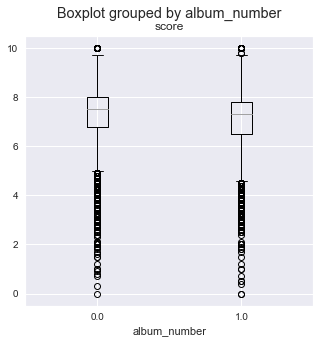

Text(0, 0.5, 'Counts')

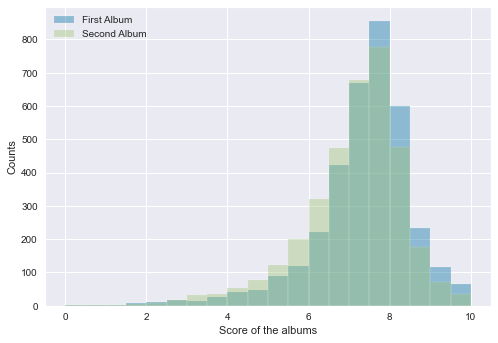

In [36]:
#5.3.2

fs = pd.concat([first_album, second_album])
fs.boxplot(by='album_number', column='score', figsize = [5, 5], grid=True)
plt.show()
#distribution 
score1 = first_album['score']
score2 = second_album['score']

score1.hist( bins = 20, alpha = 0.4)
score2.hist(bins = 20, alpha = 0.4)
plt.legend(["First Album", "Second Album "])
plt.xlabel("Score of the albums")
plt.ylabel("Counts")

In [37]:
#5.4

# We want to use T test but we first need to check that the distribution is normal 
# Check if data come from a normal distrbution
print(diagnostic.kstest_normal(first_album['score'], dist = 'norm'))
print(diagnostic.kstest_normal(second_album['score'], dist = 'norm'))
# We can see that the p values are not small so the hypothesis that they follow a normal distribution is not rejected. 
ttest_ind(first_album['score'], second_album['score'], equal_var=False)

(0.1181505568032693, 0.0009999999999998899)
(0.1111415476362363, 0.0009999999999998899)


Ttest_indResult(statistic=8.55573289201752, pvalue=1.4190102387973813e-17)

The p value is very small here, it is, in particular, less than 0.05. Hence we reject the null hypothesis that the means are the same. This means that there is a significant difference of the average score of the first and second album.

##### 5.5

We calculated the p-value for an unpaired one-tailed test (since we want to know if the first album has a higher score than the second). The P-value for the t-test is very small, in particular, less than 0.05. Hence we reject the null hypothesis. This means that there is a significant difference so the score of the first album should be higher than the second album.

Because of this t-test, we know that that the difference between the means is statistically significant. And we can see for the histograms, that the number of first album with score greater than 6 is are always bigger than the second album. And in contrary there are more second albums than first albums with score less than 6. All these informations confirms that the "second album syndrome" exists. 

**Task 6 (Regression analysis — 20 pts)**

Next, you proceed to examine some hypotheses about the "second album syndrome" using a regression framework. Namely:

- The **time spent hypothesis:**  the first album usually has a couple of years of development under its belt and plenty of trial and error from live concerts to help the band determine what does or doesn't work. The second album, on the other hand, is often made in a rush.

- The **style change hypothesis:** bands often try to change their style after their first album. This change is not always welcomed by the listeners.

1. Create a new dataframe containing one row per 1st-2nd album pair. The dataframe should contain rows:
    - `score_diff`: the difference in scores between the second and the first album (second - first).
    - `time_diff`: the number of days elapsed between the first and the second album.
    - `did_style_change`: a dummy variable that indicates whether the style of the music has changed. To obtain it, first, calculate the [standardized euclidean distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.seuclidean.html) of music-related numerical features¹ between the second and the first album. Second, assign 1 to the 20% most distant 1st-2nd album pairs and 0 to all others.
2. Fit a linear regression using `statsmodels` with this dataframe. Your regression should consider only an intercept, i.e., `"score_diff ~ 1"`.
3. **Discuss:** Interpret the $R^2$ in your regression here. Does this analysis confirm what you observed in Task 5? Why?
4. Include the `time_diff` and `did_style_change` as covariates in your model. Fit the regression again and report the summary of your model. 
5. **Discuss:** Interpret the coefficients `time_diff` and `did_style_change`. Carefully explain whether they provide evidence towards each of the aforementioned hypotheses? Do they rule out other reasons that may cause the "second album syndrome effect"?
6. Create a new column called `time_diff_standardized`. It should be a standardized version of the `time_diff` column. Repeat the regression done in 6.4 using the `time_diff_standardized` column instead of the `time_diff` column.
7. **Discuss:** Explain how the interpretation of the coefficients associated with this new column `time_diff_standardized` differ from its non-standardized version 
`time_diff`?

--- 

**¹** Music related numerical features are:  "key", "acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "valence", and "tempo".


In [38]:
# 6.1

# Get the first and second albums and sort them by artist
d6_first = d5[d5['album_number'] == 0].sort_values(by=['artist']).reset_index().drop(labels=['index'],axis=1)
d6_second = d5[d5['album_number'] == 1].sort_values(by=['artist']).reset_index().drop(labels=['index'],axis=1)
print(d6_first.shape)
print(d6_second.shape)
d6_first.head(3)

(3564, 19)
(3564, 19)


,artist,album,reviewauthor,score,releaseyear,reviewdate,recordlabel,genre,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,album_number
0,!!!,Split EP,Dominique Leone,6.0,1999.0,February 12 2004,GSL,Rock,0.470000,0.909500,6.000000,-4.112000,0.095600,0.000449,0.000000,0.177500,0.596500,97.046500,0.0
1,(Sandy) Alex G,Rocket,Ian Cohen,8.4,2017.0,May 19 2017,Domino,Rock,0.461143,0.588929,6.071429,-7.042714,0.049843,0.283422,0.313242,0.222736,0.462714,128.357714,0.0
2,...And You Will Know Us by the Trail of Dead,Madonna,Stuart Berman,8.7,1999.0,November 10 2019,none,Rock,0.614667,0.634583,5.750000,-7.213667,0.047150,0.324892,0.110828,0.220633,0.484750,118.323500,0.0


In [39]:
# Make a series for score_diff
score_diff = d6_second['score'] - d6_first['score']
score_diff.head(3)

0    1.0
1    0.2
2   -0.1
Name: score, dtype: float64

In [40]:
# Make a series for time_diff assuming its 365 days in all years
time_diff = (d6_second['releaseyear'] - d6_first['releaseyear'])*365
time_diff.head(3)

0    1825.0
1     730.0
2     730.0
Name: releaseyear, dtype: float64

In [41]:
# Make one dataframe for each of the first and second albums only including features that is related to style change
style_change_df_a = d6_first[['key', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tempo']]
style_change_df_b = d6_second[['key', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tempo']]
style_change_df_a.head(3)

,key,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo
0,6.000000,0.000449,0.470000,0.909500,0.000000,0.177500,-4.112000,0.095600,0.596500,97.046500
1,6.071429,0.283422,0.461143,0.588929,0.313242,0.222736,-7.042714,0.049843,0.462714,128.357714
2,5.750000,0.324892,0.614667,0.634583,0.110828,0.220633,-7.213667,0.047150,0.484750,118.323500


In [42]:
# Calculate the standardized euclidean distance between the features of the first and second albums
style_change_num = []
for i in range(len(style_change_df_a)):
    style_change_num.append(seuclidean(style_change_df_a.iloc[i].to_numpy(), 
                                       style_change_df_b.iloc[i].to_numpy(), 
                                       np.ones(style_change_df_a.shape[1])))

In [43]:
# Make a copy of the euclid dist and sort it
r = style_change_num.copy()
r.sort()

ind = math.floor(len(style_change_num)*0.8)
# Find the threshhold value for the largest 20% of values
tresh = r[ind]
print('treshhold value for style change:', tresh)

treshhold value for style change: 24.271989134973573


In [44]:
# Assign 1 to values over threshhold else 0
did_style_change = np.where(np.array(style_change_num) >= tresh, 1, 0)

# Turn the series into a dataframe and display it
df6_dict = {'score_diff' : score_diff, 'time_diff' : time_diff, 'did_style_change' : did_style_change}
df6 = pd.DataFrame(df6_dict)
df6.head(7)

,score_diff,time_diff,did_style_change
0,1.0,1825.0,0
1,0.2,730.0,0
2,-0.1,730.0,0
3,0.0,0.0,0
4,-2.1,2190.0,0
5,-0.2,1460.0,0
6,-3.2,730.0,1


In [45]:
# 6.2

results = smf.ols('score_diff ~ 1', data=df6).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             score_diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 26 Nov 2021   Prob (F-statistic):                nan
Time:                        21:18:51   Log-Likelihood:                -6222.4
No. Observations:                3564   AIC:                         1.245e+04
Df Residuals:                    3563   BIC:                         1.245e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2545      0.023    -10.957      0.0

##### 6.3

**Discuss:** Interpret the  𝑅2  in your regression here. Does this analysis confirm what you observed in Task 5? Why?

The R2 is 0 in this regression. It means 0 of the proportion of the variance for a dependent variable is explained by no independent variable in the regression model. This confirms that the score difference is not due to randomness or noise.

In [46]:
# 6.4

results3 = smf.ols('score_diff ~ time_diff + did_style_change', data=df6).fit()
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:             score_diff   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     35.57
Date:                Fri, 26 Nov 2021   Prob (F-statistic):           5.07e-16
Time:                        21:18:51   Log-Likelihood:                -6187.1
No. Observations:                3564   AIC:                         1.238e+04
Df Residuals:                    3561   BIC:                         1.240e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.1421      0.030  

##### 6.5

**Discuss:** Interpret the coefficients time_diff and did_style_change. Carefully explain whether they provide evidence towards each of the aforementioned hypotheses? Do they rule out other reasons that may cause the "second album syndrome effect"?

The coefficient of time_diff is very small and negative, which can be seen as the score of an album decreses the longer the wait between the albums. Since it is very small, the effect won't be important. Style_change is slightly positive, so this means that an album that has a different style than the precedent generally have a better score. In fact, when reading the p-value associated to this variable, it is a big value and so the influence of the change is not explained and can be dut to chance.

We don't know if they rule out other reasons that could cause the "second album syndrome effect".

In [47]:
# 6.6

df6['time_diff_standardized'] = ((time_diff - time_diff.mean()) / time_diff.std())

results5 = smf.ols('score_diff ~ time_diff_standardized + did_style_change', data=df6).fit()
print(results5.summary())

                            OLS Regression Results                            
Dep. Variable:             score_diff   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     35.57
Date:                Fri, 26 Nov 2021   Prob (F-statistic):           5.07e-16
Time:                        21:18:51   Log-Likelihood:                -6187.1
No. Observations:                3564   AIC:                         1.238e+04
Df Residuals:                    3561   BIC:                         1.240e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

##### 6.7

**Discuss:** Explain how the interpretation of the coefficients associated with this new column time_diff_standardized differ from its non-standardized version time_diff?

With the standardized change we have a much larger effect, but it's negative which means that the score decreases due to longer time diff, which is the opposite of the hypothesis.

**Task 7 (Sanity checks — 6 pts)**

You decide to perform a few last sanity checks for your analysis.

1.  **Discuss:** If the Second Album Syndrome existed, i.e., something was special about the second album (as in if it was bad for a very particular reason that afflicted album number 2 more than all others), what would you expect to happen to the mean score of the third album?
2. Using the dataset you created in Task 5, calculate the mean and the standard error of the mean for the 1st, 2nd, 3rd, and 4th albums. Test whether the difference between the average score of the second and the third album is statistically significant.
3. **Discuss:** Does this suggest that the Second Album Syndrome exists?

---


##### 7.1
If the second Album Syndrome existed, this means that we want to show that this album in particular has a low score compared to the others (and not only the first album): So this means that we expect that the mean score of the third album to be better than the second one. 

In [48]:
#7.2

third_album = d5[d5['album_number'] == 2]
forth_album = d5[d5['album_number'] == 3]

print('First album - Mean: {}   Standard error of the mean: {}'.format(first_album['score'].mean(), sem(first_album['score'])))
print('Second album - Mean: {}    Standard error of the mean: {}'.format(second_album['score'].mean(), sem(second_album['score'])))
print('Third album - Mean: {}    Standard error of the mean: {}'.format(third_album['score'].mean(), sem(third_album['score'])))
print('Forth album - Mean: {}    Standard error of the mean: {}'.format(forth_album['score'].mean(), sem(forth_album['score'])))

print()

#In order to compare the second and third album,we take the second album of an artist only if he had a third album:
# The test will be more significative because if we let the artist who made only two album, we can't argue that with 
# the other third albums, the second album syndrom exists. 
artist3 = third_album['artist']
second_album_3 = d5[(d5['artist'].isin(artist3))&(d5['album_number']==1)]

# Check that the df have the same shapes
print('Same shapes of second_album_3 and third_album:', second_album_3.shape == third_album.shape)

# We know have to sets with same size, let's make the t-test : 
ttest_ind(second_album_3['score'],third_album['score'])

First album - Mean: 7.296548821548822   Standard error of the mean: 0.02076505342146367
Second album - Mean: 7.0420033670033675    Standard error of the mean: 0.02130636759493283
Third album - Mean: 7.053179487179488    Standard error of the mean: 0.02741993976718128
Forth album - Mean: 7.042190152801359    Standard error of the mean: 0.03595891985530085

Same shapes of second_album_3 and third_album: True


Ttest_indResult(statistic=3.7894886571072672, pvalue=0.00015323782176787393)

##### 7.3
The results that we get suggest that the Second Album Syndrome exists. First,in order to compare the third album with the second we first extracted all the artist from the second album that didn't have a third album. Otherwise the test won't have a big signification. When we did that, we found a p-value smaller than 0.05. Hence, the null hypthesis is rejected. The null hypothesis claims that the average score of the second and third album's score are equal. In conclusion, the difference between the average score of the second and the third album is statistically significant.

**Task 8 (Eureka — 14 pts)**

Your boss, *Signor Piccardi*, proposes that you carry out a simulation to make things clearer. Assuming that:


- Each band $i$ has a "talent" $\mu_i$ , which is uniformally distributed between 2 and 8, i.e., $\mu_i \sim U_{[2,8]}$.
- When a band $i$ produces an album $j$, it has quality $s_j$. This score is normally distributed with mean $\mu_i$ and standard deviation $1$, i.e., $s_j \sim N(\mu_i, 1)$
- Talents are independent and identically distributed random variables.
 
Carry out the following simulation:

- Create 1000 hypothetical bands with intrinsic talents $\mu_i \sim U_{[2,8]}$ for $i \in [1,1000]$.
- Have each hypothetical band create a hypothetical album.
- Discard all bands whose albums received a score smaller than 6.
- For each of the remaining bands, create two additional albums.

Analyzing the scores obtained in this simulation, provide a coherent explanation for the  scores obtained in Task 7.2. 

--- 

**Hint:** You can use numpy to sample random variables (e.g. [numpy.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html))

In [49]:
#8

j = {'talent' : np.random.uniform(low=2, high=8, size=1000)}

In [50]:
# Create a dataframe for the bands with given talents
bands = pd.DataFrame.from_dict(j)
bands

,talent
0,6.871627
1,4.698023
2,4.047414
3,7.765254
4,4.647922
...,...
995,5.136158
996,6.181466
997,6.490871
998,2.400897


In [51]:
# Create the score of the first album from the normal distribution of the talents
bands['album1'] = np.random.normal(loc=bands['talent'], scale=1, size=1000)
bands

,talent,album1
0,6.871627,7.892303
1,4.698023,3.957742
2,4.047414,5.349886
3,7.765254,9.145514
4,4.647922,2.501527
...,...,...
995,5.136158,4.206952
996,6.181466,6.114456
997,6.490871,7.134349
998,2.400897,2.014860


In [52]:
# Drop all bands that published the first album with score less than 6
bands = bands[bands['album1'] >= 6]
bands

,talent,album1
0,6.871627,7.892303
3,7.765254,9.145514
5,7.876124,8.781971
6,7.475648,8.970883
8,6.037551,6.008424
...,...,...
983,7.945066,8.975181
984,7.131638,7.518084
993,7.061377,7.869644
996,6.181466,6.114456


In [53]:
# Make an extended dataset with albums 2 and 3 (to avoid copy warnings)
bandsExt = bands.loc[:]
bandsExt['album2'] = np.random.normal(bands['talent'])
bandsExt['album3'] = np.random.normal(bands['talent'])

bandsExt

,talent,album1,album2,album3
0,6.871627,7.892303,7.084291,8.017439
3,7.765254,9.145514,7.432829,8.644868
5,7.876124,8.781971,10.984694,7.621233
6,7.475648,8.970883,6.565937,6.463741
8,6.037551,6.008424,4.633153,7.472694
...,...,...,...,...
983,7.945066,8.975181,8.056505,7.954461
984,7.131638,7.518084,6.197034,5.477825
993,7.061377,7.869644,6.544235,8.941383
996,6.181466,6.114456,6.280540,7.115156


##### 8 Analysis

In [54]:
gen = [bandsExt['album1'], bandsExt['album2'], bandsExt['album3']]
real = [first_album['score'], second_album['score'], third_album['score']]

print('First generated album - Mean: {}'.format(bandsExt['album1'].mean()))
print('Second generated album - Mean: {}'.format(bandsExt['album2'].mean()))
print('Third generated album - Mean: {}'.format(bandsExt['album3'].mean()))

First generated album - Mean: 7.262574921904278
Second generated album - Mean: 6.6903724272809795
Third generated album - Mean: 6.7229828678728465


In [55]:
#From task 7.2
print('First album - Mean: {}'.format(first_album['score'].mean()))
print('Second album - Mean: {}'.format(second_album['score'].mean()))
print('Third album - Mean: {}'.format(third_album['score'].mean()))

First album - Mean: 7.296548821548822
Second album - Mean: 7.0420033670033675
Third album - Mean: 7.053179487179488


We can see that from the simulation that the average score for the second and third generated album the score is lower than for the first one. As we saw in task 7.2 The average score is lower for the second album and the third compared to the first one aswell.
The difference between the second and third generated album is really small (just like the real one), and due to it being generated at random anyone of them can be higher or lower than the other.

In [56]:
for i in range(len(gen)):
    print("Difference of the mean of album {} from the actual data and the simulation is: {}"
          .format(i+1, real[i].mean()-gen[i].mean()))

Difference of the mean of album 1 from the actual data and the simulation is: 0.033973899644544225
Difference of the mean of album 2 from the actual data and the simulation is: 0.351630939722388
Difference of the mean of album 3 from the actual data and the simulation is: 0.33019661930664146


We can see that model is not that far off the score for the first album, but further and almost equal away for the second and third album. It does not seem like an too unreasonable model to make an hypothesis around.

We think the idea of this simulation is to think of a third hypothesis: Out of all bands, some end up making a good first album (either due to luck or talent or both), but only the ones that made a good album in the first place continue to make more. Then we have the problem of survivorship bias, if a band with not that much talent, but a lot of luck for their first album just passed the threshhold for a good enough album to make one more, it is likely that the next one will be worse.
But for the higher end of the spectrum, there are no bands that pull the disbribution higher up in score for the second album so the mean will be lower.
Now if the condition for keeping on making albums is just that the first one was good, we will have all consecutive albums be around the mean of the second album. (This is what the model predicts) But in reality some bands that perform very bad on their second album may also stop producing, which increases the mean of the third album and continuing on depending on how many of the "high talent" bands that continue producing.